In [23]:
# Python packages used:
import numpy as np # (Harris et al., 2024)
import matplotlib.pyplot as plt # # (Hunter, 2007)
import pandas as pd # (The pandas development team, 2020)
from scipy.stats import gumbel_r, linregress

## Calucalting discharge return periods

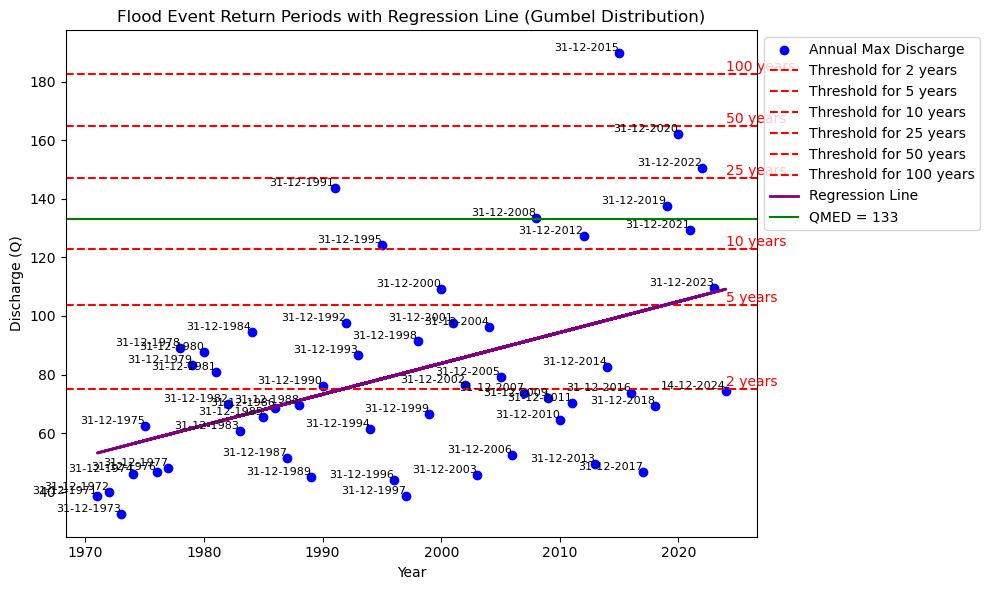

In [21]:
# Read the CSV file containing the discharge time series
Elland_Q_comObs = pd.read_csv('Elland_Q_complete_obs.csv', parse_dates=['date'], dayfirst=True)

# Extract the year and discharge
Elland_Q_comObs['year'] = Elland_Q_comObs['date'].dt.year
annual_max = Elland_Q_comObs.groupby('year')['Q'].max()  # Annual maximum discharge values

# Fit a Gumbel distribution to the annual maximum series
params = gumbel_r.fit(annual_max)

# Calculate the return period for each discharge value
def return_period(q):
    return 1 / (1 - gumbel_r.cdf(q, *params))

# Sort the discharge values in descending order
sorted_annual_max = annual_max.sort_values(ascending=False)

# Calculate the return period for each sorted discharge
sorted_return_periods = sorted_annual_max.apply(return_period)

# Perform linear regression on the AMAX values
years = sorted_annual_max.index.values  # Use the year as the x-axis
amax_values = sorted_annual_max.values   # Use the AMAX discharge values as the y-axis

slope, intercept, r_value, p_value, std_err = linregress(years, amax_values)

# Generate the regression line values
regression_line = slope * years + intercept

# Plot the discharge values with return period thresholds
plt.figure(figsize=(10, 6))
plt.scatter(sorted_annual_max.index, sorted_annual_max.values, label='Annual Max Discharge', color='blue')

# Label each point with the corresponding date
for year, discharge in zip(sorted_annual_max.index, sorted_annual_max.values):
    # Get the full date for each year
    date_label = Elland_Q_comObs[Elland_Q_comObs['year'] == year]['date'].max().strftime('%d-%m-%Y')
    plt.text(year, discharge, date_label, fontsize=8, ha='right', va='bottom', color='black')

# Define return periods for plotting thresholds (e.g., 2, 5, 10, 50, 100 years)
threshold_return_periods = [2, 5, 10, 25, 50, 100]
for rp in threshold_return_periods:
    threshold_q = gumbel_r.ppf(1 - 1/rp, *params)
    plt.axhline(y=threshold_q, color='red', linestyle='--', label=f'Threshold for {rp} years')

    # Annotate the return period on the plot
    plt.text(
        max(sorted_annual_max.index),  # Place text near the far-right side of the plot
        threshold_q,  # y-position (discharge value)
        f'{rp} years',  # Text to display
        color='red',
        verticalalignment='bottom',  # Align text below the line
        horizontalalignment='left',  # Align text to the left
        fontsize=10
    )

# Plot the regression line
plt.plot(years, regression_line, color='purple', label='Regression Line', linestyle='-', linewidth=2)

# QMED threshold (given)
QMED = 133
plt.axhline(y=QMED, color='green', linestyle='-', label=f'QMED = {QMED}')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Discharge (Q)')
plt.title('Flood Event Return Periods with Regression Line (Gumbel Distribution)')

# Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Adjust layout to make room for the legend
plt.tight_layout()

# Show plot
plt.show()
